In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from mujoco_py import load_model_from_path, MjSim
from scipy.stats import truncnorm


from soft_tissues_eval.utils import edit_MjModel_cmp_smoothness
from shared_utils.general import get_project_root, models_folder_path
from soft_tissues_eval.soft_compression_eval import execute_pre_compression, execute_compression
from monte_carlo.sample_models import get_solref_stiff_sample, generate_solrefsmooth_params
from monte_carlo.constants import SOLREF_STIFF_LB, SOLREF_STIFF_UB, SOLREF_STIFF_MEAN, SOLREF_STIFF_STD

In [3]:
%matplotlib inline

The results of some computation are cached in files.

In [4]:
cache_folder_path = os.path.join(get_project_root(), "bin", "outputs", "mc_softness_sampling")
assert os.path.isdir(cache_folder_path)

## Estimate correct range for solref - stiffness parameter

We use the compression test model and iterate over the stiffness.

In [5]:
model_path = os.path.join(models_folder_path(), "soft_tissues", "compression_test_with_solref.xml")
assert os.path.isfile(model_path)


model = load_model_from_path(model_path)

# prefix of the evaluated composite body
cmp_prefix = "cmp_"

# get ref micro element for composite body width
# they are colored in green and blue
GREEN_RGBA = np.array([0.2, 0.8, 0.1, 1], dtype=np.float32)
BLUE_RGBA = np.array([0.1, 0.2, 0.8, 1.], dtype=np.float32)

green_bodies_idx = np.nonzero((model.geom_rgba == GREEN_RGBA).all(axis=1))
blue_bodies_idx = np.nonzero((model.geom_rgba == BLUE_RGBA).all(axis=1))

print(green_bodies_idx, blue_bodies_idx)

(array([27, 28]),) (array([155, 156]),)


Constant damping but modification of the stiffness parameter.

In [6]:
# draw uniform samples of solref stiffness
# solref_stiffs = np.arange(-100, -2150, -250)
solref_stiffs = np.arange(-100, -1050, -125)

solref_damps = np.full_like(solref_stiffs, -111.)
solrefs = np.column_stack((solref_stiffs, solref_damps))

print(solrefs)

[[-100 -111]
 [-225 -111]
 [-350 -111]
 [-475 -111]
 [-600 -111]
 [-725 -111]
 [-850 -111]
 [-975 -111]]


In [7]:
# check if the result of the computation has not yet been cached
final_states_path = os.path.join(cache_folder_path,'final_compression_states.npy')

if(os.path.isfile(final_states_path)):
    final_compression_states = np.load(final_states_path)

else:
    final_compression_states = np.zeros((0, 2))

    for i, solref in enumerate(solrefs):
        # set solref
        edit_MjModel_cmp_smoothness(model, cmp_prefix, solref)

        # extract useful element indexes
        compressor_body_name = "compressor"
        compressor_body_index = model.body_names.index(compressor_body_name)
        compressor_joint_name = "compressor_slide"
        compressor_joint_index = model.joint_name2id(compressor_joint_name)
        compressor_act_index = 0
        soft_body_name = "test_collider"
        soft_body_index = model.body_names.index(soft_body_name)

        # init simulation
        sim = MjSim(model)
        sim.forward()  # ensure that everything is initialized in the sim object

        print(f"Starting pre compression of soft body {i} ...")

        # execute pre compression
        execute_pre_compression(model, sim, compressor_body_index, compressor_joint_index,
                                compressor_act_index)

        print(f"Starting compression of soft body {i} ...")

        # execute compression
        soft_body_width, force_array = execute_compression(sim, compressor_body_index,
            compressor_act_index, force_step=10., green_bodies_idx=green_bodies_idx, blue_bodies_idx=blue_bodies_idx)

        final_compression_states = np.vstack((final_compression_states, 
                                        np.array([soft_body_width[-1], force_array[-1]])))

    # save in file
    np.save(final_states_path, final_compression_states)

#### Estimate the compression surface S

In [8]:
# init simulation (we need a few pos measurements)
sim = MjSim(model)
sim.forward()

#  measure initial width of the composite body
green_mean_x = np.mean(sim.data.body_xpos[green_bodies_idx, 0])
blue_mean_x = np.mean(sim.data.body_xpos[blue_bodies_idx, 0])
cmp_init_width = np.abs(green_mean_x - blue_mean_x)

print(f"Initial width of the composite body: {cmp_init_width}")


# measure length of the composite body
top_micro_elememt = "cmp_B2_2_9"
bottom_micro_element = "cmp_B2_2_0"

top_idx = model.body_name2id(top_micro_elememt)
bottom_idx = model.body_name2id(bottom_micro_element)

top_pos = sim.data.body_xpos[top_idx]
bottom_pos = sim.data.body_xpos[bottom_idx]

cmp_length = np.linalg.norm(top_pos - bottom_pos)

print(f"Length of composite body: {cmp_length}")

# deduce approximative compression surface
S_approx = cmp_length*cmp_init_width

print(f"Compression surface approximation: {S_approx}")

Initial width of the composite body: 0.07770260000000001
Length of composite body: 0.18
Compression surface approximation: 0.013986468000000002


#### Deduce Young modulus

$E = \sigma / \epsilon = F / \Delta l \times l_0 / S$

In [9]:
unscaled_modulus = final_compression_states[:,1] / final_compression_states[:,0]
absolute_young_modulus = unscaled_modulus*cmp_init_width/S_approx

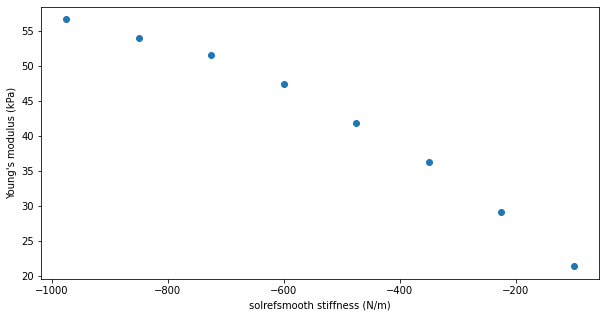

In [10]:
plt.figure(figsize=(10, 5))
plt.scatter(solref_stiffs, absolute_young_modulus/1000.)
plt.ylabel("Young's modulus (kPa)")
plt.xlabel("solrefsmooth stiffness (N/m)")

plt.show()

In [11]:
young_mod_reg = LinearRegression().fit(solref_stiffs.reshape(-1, 1), absolute_young_modulus/1000)
r2 = young_mod_reg.score(solref_stiffs.reshape(-1, 1), absolute_young_modulus/1000)
print(f"R2 score of regression: {r2}")

R2 score of regression: 0.9641416355629971


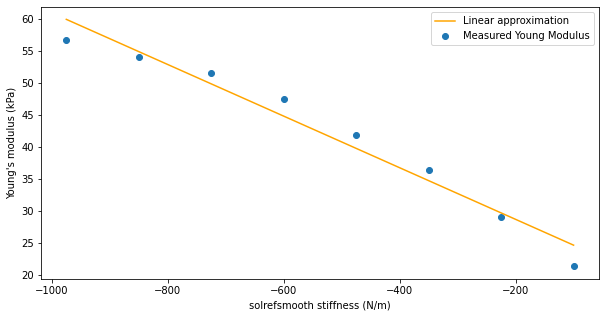

In [29]:
solref_array = np.linspace(solref_stiffs[0], solref_stiffs[-1], 50)
linear_modulus = young_mod_reg.predict(solref_array.reshape(-1,1))

plt.figure(figsize=(10, 5))
plt.scatter(solref_stiffs, absolute_young_modulus/1000., label="Measured Young Modulus")
plt.plot(solref_array, linear_modulus, color='orange', label="Linear approximation")
plt.ylabel("Young's modulus (kPa)")
plt.xlabel("solrefsmooth stiffness (N/m)")
plt.legend()

plt.show()

Let's restrict ourselves to this interval where the evoluation is roughly linear.

In [12]:
print(f"Upper bound solrefsmooth stiffness: {solref_stiffs[0]}")
print(f"Lower bound solrefsmooth stiffness: {solref_stiffs[-1]}")

Upper bound solrefsmooth stiffness: -100
Lower bound solrefsmooth stiffness: -975


## Define softness sampler

A visualisation of the theoretical distribution + one draw is provided.

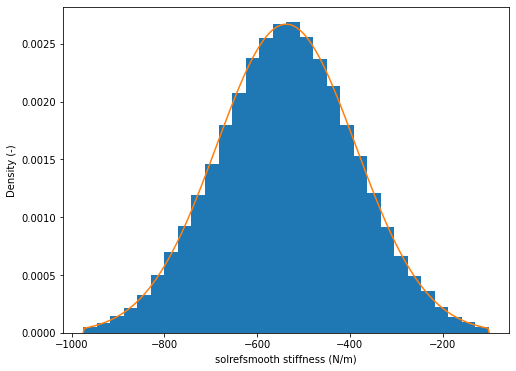

In [13]:
a, b = (SOLREF_STIFF_LB - SOLREF_STIFF_MEAN)/SOLREF_STIFF_STD, (SOLREF_STIFF_UB - SOLREF_STIFF_MEAN)/SOLREF_STIFF_STD
x_array = np.linspace(SOLREF_STIFF_LB-.05, SOLREF_STIFF_UB+.05, 400)


n_samples = (100000,)
samples_draw = get_solref_stiff_sample(n_samples)
plt.figure(figsize=(8,6))
plt.hist(samples_draw, density=True, bins=30)
plt.plot(x_array, truncnorm.pdf(x_array, a, b, loc=SOLREF_STIFF_MEAN, scale=SOLREF_STIFF_STD))
plt.xlabel("solrefsmooth stiffness (N/m)")
plt.ylabel("Density (-)")
plt.show()

Visualisation in the Young Modulus space.

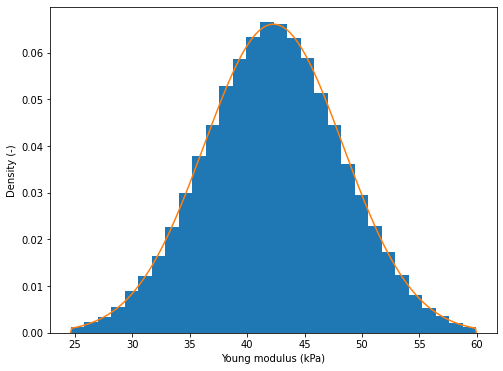

In [25]:
# convert solrefsmooth samples in young modulus
young_mod_samples = young_mod_reg.predict(samples_draw.reshape(-1, 1))

# modulus follows a gaussian distribution as well
modulus_array = np.linspace((SOLREF_STIFF_LB-.05)*young_mod_reg.coef_[0] + young_mod_reg.intercept_,
 (SOLREF_STIFF_UB+.05)*young_mod_reg.coef_[0] + young_mod_reg.intercept_, 400)
modulus_density = truncnorm.pdf(modulus_array, a, b, 
    loc = SOLREF_STIFF_MEAN*young_mod_reg.coef_[0]+young_mod_reg.intercept_,
    scale = SOLREF_STIFF_STD*np.abs(young_mod_reg.coef_)[0])

plt.figure(figsize=(8,6))
plt.hist(young_mod_samples, density=True, bins=30)
plt.plot(modulus_array, modulus_density)
plt.xlabel("Young modulus (kPa)")
plt.ylabel("Density (-)")
plt.show()

Generating solref is not exactly the same; we generate solref independently for upper and lower arm, with a fixed damping parameter (=-111)

In [15]:
generate_solrefsmooth_params(5)

{'ua_solrefsmooth': array([[-862.82535935, -111.        ],
        [-620.70539728, -111.        ],
        [-360.89414295, -111.        ],
        [-622.78048604, -111.        ],
        [-365.48703632, -111.        ]]),
 'la_solrefsmooth': array([[-532.74444164, -111.        ],
        [-459.36727628, -111.        ],
        [-789.33196262, -111.        ],
        [-546.21916414, -111.        ],
        [-584.20621478, -111.        ]])}